In [43]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


IMPORTING REQUIRED LIBRARIES

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_curve, auc
)
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

LOADING THE DATA

In [56]:
path = r'C:\Users\ASUS\Desktop\jupyter projects\dataset1.csv'
df = pd.read_csv(path)
df.fillna(0, inplace=True)

VISUALIZING CLASS DISTRIBUTION OF DATA

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20904\2306684881.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Label'], palette="coolwarm")


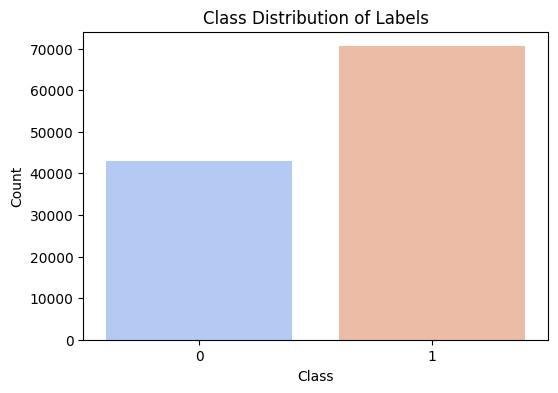

In [58]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df['Label'], palette="coolwarm")
plt.title("Class Distribution of Labels")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

PREPROCESSING DATA

STANDARDIZING FEATURES

In [59]:
X = df.drop('Label', axis=1).values
y = pd.factorize(df['Label'])[0]
scaler = StandardScaler()
X = scaler.fit_transform(X)

TRAIN-TEST SPLIT WITH STRATIFICATION

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

CREATING CUSTOM DATASET

In [49]:
class CustomDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

DEFINING THE MODEL

In [50]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

DEFINING TRAINING FUNCTION

In [51]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

DEFINING TESTING FUNCTION

In [52]:
def test(model, test_loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
    return correct / len(test_loader.dataset)

EVALUATING THE MODEL

In [53]:
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            probabilities = torch.softmax(output, dim=1)
            preds = output.argmax(dim=1)

            y_true.extend(target.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probabilities.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    plt.figure(figsize=(8, 6))
    for class_idx in range(len(np.unique(y_train))):
        fpr, tpr, _ = roc_curve(np.array(y_true) == class_idx, np.array(y_prob)[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {class_idx} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Probability Distribution Graph
    plt.figure(figsize=(8, 6))
    sns.histplot(np.array(y_prob).flatten(), bins=20, kde=True, color='purple')
    plt.title("Distribution of Predicted Probabilities")
    plt.xlabel("Probability")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

IMPLEMENTING FEDERATED LEARNING

In [54]:
def federated_learning(num_clients=5, num_rounds=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_dim = X_train.shape[1]
    output_dim = len(np.unique(y_train))
    global_model = Net(input_dim, output_dim).to(device)
    criterion = nn.CrossEntropyLoss()

    client_loaders = []
    split_size = len(train_dataset) // num_clients
    for i in range(num_clients):
        client_data = data.DataLoader(
            data.Subset(train_dataset, list(range(i * split_size, (i + 1) * split_size))),
            batch_size=32, shuffle=True
        )
        client_loaders.append(client_data)

    for round_num in range(num_rounds):
        print(f"Round {round_num + 1}/{num_rounds}")
        client_models = []

        for client_loader in client_loaders:
            model = Net(input_dim, output_dim).to(device)
            model.load_state_dict(global_model.state_dict())
            optimizer = optim.Adam(model.parameters(), lr=0.0003)

            train(model, client_loader, criterion, optimizer, device)
            client_models.append(model.state_dict())

        global_state_dict = global_model.state_dict()
        for key in global_state_dict.keys():
            global_state_dict[key] = torch.stack([client_model[key] for client_model in client_models]).mean(0)

        global_model.load_state_dict(global_state_dict)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    accuracy = test(global_model, test_loader, device)
    print(f"Final Test Accuracy: {accuracy:.4f}")

    evaluate_model(global_model, test_loader, device)

RUNNING FEDERATED LEARNING IMPLEMENTATION

Round 1/10
Round 2/10
Round 3/10
Round 4/10
Round 5/10
Round 6/10
Round 7/10
Round 8/10
Round 9/10
Round 10/10
Final Test Accuracy: 0.9996

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8580
           1       1.00      1.00      1.00     14102

    accuracy                           1.00     22682
   macro avg       1.00      1.00      1.00     22682
weighted avg       1.00      1.00      1.00     22682



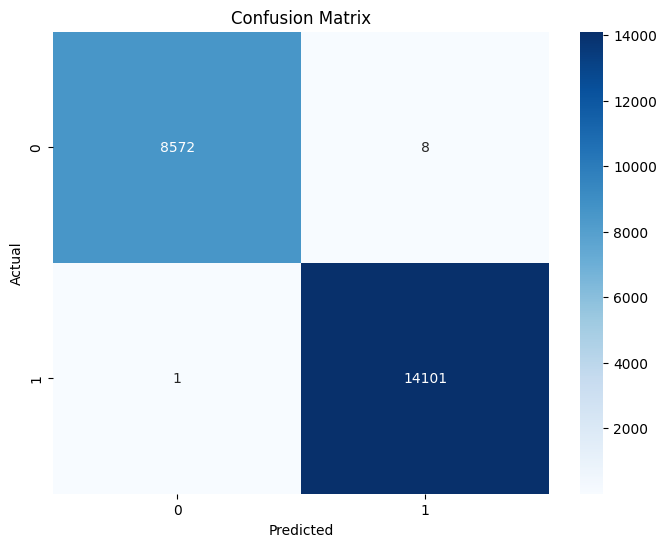

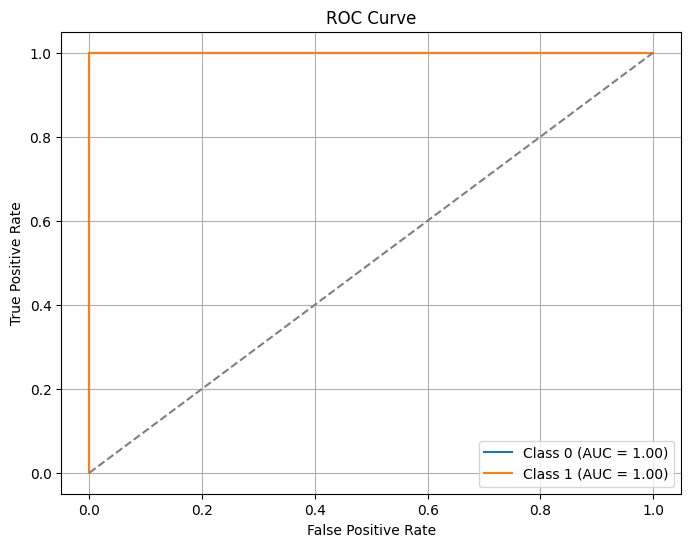

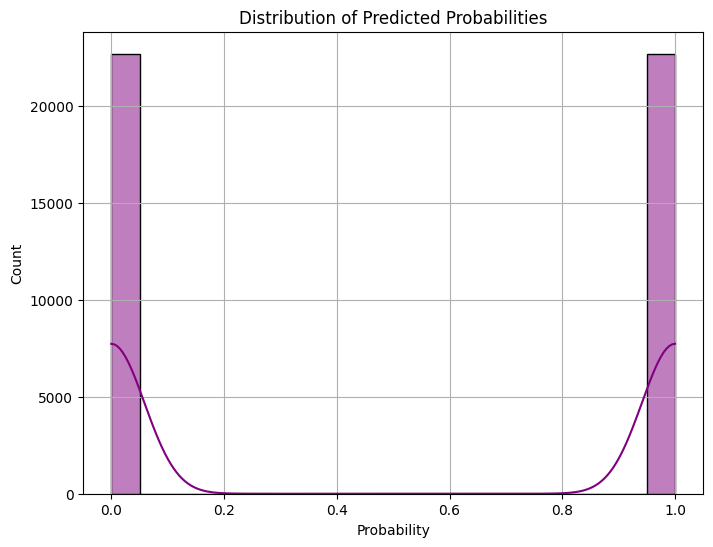

In [55]:
federated_learning()